<a href="https://colab.research.google.com/github/z26qin/DDK_SDK/blob/master/Index_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# prompt: testing linear regression on yahoo finance nasdaq 2024 data

!pip install yfinance
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import os




In [35]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [36]:
sp500.index = pd.to_datetime(sp500.index)


In [37]:
sp500.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


<Axes: xlabel='Date'>

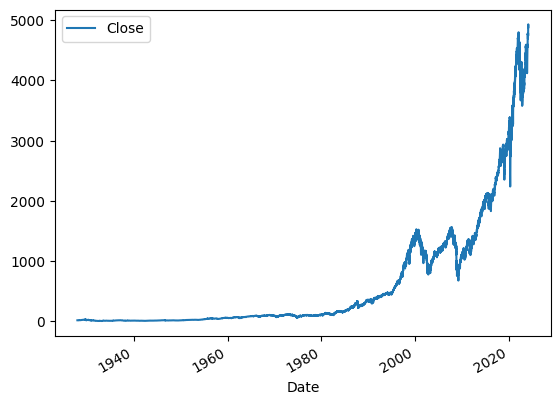

In [38]:
sp500.plot.line(y="Close", use_index=True)

In [39]:
sp500['Tomorrow']=sp500['Close'].shift(-1)
sp500['Target']=(sp500['Tomorrow']>sp500['Close']).astype(int)
sp500.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target
Date,,,,,,,,,
2024-01-25 00:00:00-05:00,4886.660156,4898.149902,4869.339844,4894.160156,4020430000,0.0,0.0,4890.970215,0
2024-01-26 00:00:00-05:00,4888.910156,4906.689941,4881.470215,4890.970215,3353400000,0.0,0.0,4927.930176,1
2024-01-29 00:00:00-05:00,4892.950195,4929.310059,4887.399902,4927.930176,3525160000,0.0,0.0,4924.970215,0
2024-01-30 00:00:00-05:00,4925.890137,4931.089844,4916.270020,4924.970215,3836130000,0.0,0.0,4881.490234,0
2024-01-31 00:00:00-05:00,4899.189941,4906.750000,4881.410156,4881.490234,634107047,0.0,0.0,NaN,0


In [40]:
sp500 = sp500.loc["1990-01-01":].copy()


In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

#decision tree and average result, resistant of overfit and pick up non linear relationship
train =sp500.iloc[:-100]
test=sp500.iloc[-100:]

predictor= ["Close", "Volume", "Open" ,"High", "Low"]
model.fit(train[predictor],train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [42]:
from sklearn.metrics import precision_score

preds=model.predict(test[predictor])

preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5348837209302325

In [43]:
combined = pd.concat([test['Target'],preds],axis=1)

<Axes: xlabel='Date'>

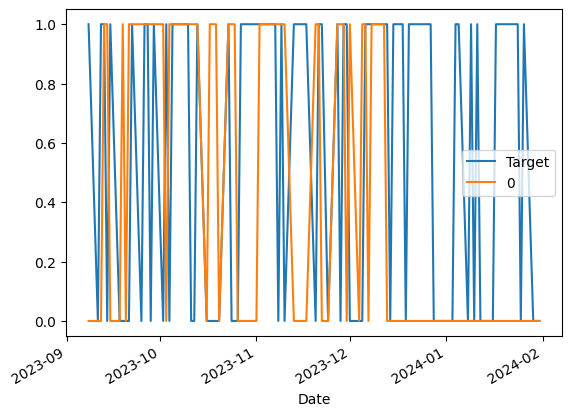

In [44]:
combined.plot()

In [45]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [46]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [47]:
predictions = backtest(sp500, model, predictor)

In [48]:
predictions['Predictions'].value_counts()

0    3490
1    2596
Name: Predictions, dtype: int64

In [49]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [50]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.534505
0    0.465495
Name: Target, dtype: float64

**rolling average **

In [51]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [52]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [53]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,0.0,0.0,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,0.0,0.0,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,0.0,0.0,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,0.0,0.0,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,0.0,0.0,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25 00:00:00-05:00,4886.660156,4898.149902,4869.339844,4894.160156,4020430000,0.0,0.0,4890.970215,0,1.002623,2.0,1.006302,5.0,1.060001,42.0,1.127490,138.0,1.224585,529.0
2024-01-26 00:00:00-05:00,4888.910156,4906.689941,4881.470215,4890.970215,3353400000,0.0,0.0,4927.930176,1,0.999674,1.0,1.003535,4.0,1.056548,41.0,1.125904,137.0,1.223311,528.0
2024-01-29 00:00:00-05:00,4892.950195,4929.310059,4887.399902,4927.930176,3525160000,0.0,0.0,4924.970215,0,1.003764,1.0,1.007913,4.0,1.061726,41.0,1.133463,138.0,1.232067,528.0


In [54]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Tomorrow', 'Target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5',
       'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000'],
      dtype='object')

In [55]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [56]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [57]:
predictions = backtest(sp500, model, new_predictors)

In [58]:
predictions["Predictions"].value_counts()

0.0    4254
1.0     832
Name: Predictions, dtype: int64

In [59]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5733173076923077

In [60]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.544239
0    0.455761
Name: Target, dtype: float64

Linear Regression

In [61]:

data = sp500[["Date", "Close"]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data["Date"], data["Close"], test_size=0.2)

# Create a linear regression model
model = LinearRegression()

from datetime import datetime
X_train = X_train.apply(lambda x: datetime.timestamp(x))
X_test = X_test.apply(lambda x: datetime.timestamp(x))

# Train the model
model.fit(X_train.values.reshape(-1, 1), y_train)

# Evaluate the model
score = model.score(X_test.values.reshape(-1, 1), y_test)

# Print the results
print("R-squared score:", score)

KeyError: "['Date'] not in index"

*Pandas quick practice*